In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import dill
import time

plt.rcParams.update({
#     "figure.facecolor":  (1.0, 1.0, 1.0, 0.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.2),  # green with alpha = 50%
#     "savefig.facecolor": (0.0, 0.0, 1.0, 0.5),  # blue  with alpha = 20%
})

In [344]:
df = pd.read_csv('mybl_ticker_all.csv')#.dropna()
df = df.rename(columns={'date_added': 'date', 'gspc': 'sp', 'vix': 'vi', 'tnx': 'tr',\
                        'ixic': 'ns', 'rut': 'ru'})
df = df.drop(['wti', 'gold'], axis=1)
df.head()

,date,sp,vi,tr,ns,ru
0,1927-12-30,17.660000,NaN,NaN,NaN,NaN
1,1928-01-03,17.760000,NaN,NaN,NaN,NaN
2,1928-01-04,17.719999,NaN,NaN,NaN,NaN
3,1928-01-05,17.549999,NaN,NaN,NaN,NaN
4,1928-01-06,17.660000,NaN,NaN,NaN,NaN


In [345]:
df['corr'] = df.sp.rolling(window=100).mean().rolling(window=100).corr(df.tr)

#Подсчет t-статистики для корреляции
def t_st(x):
    t = x['cor'] * (100 - 2)**(1/2)/(1 - x['cor']**2)**(1/2)
    t1 = stats.t.ppf(0.01/2, df=100 - 2)
    t2 = stats.t.ppf(1 - 0.01/2, df=100 - 2)

    corrt = pd.DataFrame({'cor': x['cor'], 't': t, 't1': np.ones(len(t))*t1, 't2': np.ones(len(t))*t2})
    return corrt

#Построение графиков двух рядов и корреляции с t-статистиой
def grapher(x, col1, col2):
    fig, ax = plt.subplots()
    ax.set_title('x и y')
    fig.set_size_inches(50, 5)
#     lns1 = ax.plot(x.Close.rolling(window=100, center=True).mean(), label='S&P 500')
    lns1 = ax.plot(x[col1], linewidth=1, label='x')
    ax2 = ax.twinx()
    lns2 = ax2.plot(x[col2], linewidth=1, c='r', label='y')

    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')

    fig, ax = plt.subplots()
    fig.set_size_inches(50, 5)
    ax.set_title('Корреляция между x и y')
    ax2 = ax.twinx()
    lns1 = ax.plot(corrt.t, label='t-значение')
    lns2 = ax.plot(corrt.t1, linestyle=':', c='k', label='границы критической области')
    lns3 = ax.plot(corrt.t2, linestyle=':', c='k')
    lns4 = ax2.plot(corrt['cor'], linewidth=1, linestyle='--', c='r', label='корреляция')
    ax2.set_frame_on(True)

    lns = lns1+lns2+lns4
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc='upper left')

    plt.show()


In [346]:
# df.date = pd.to_datetime(df.date)
# df.index = df.date
# corrt = t_st(df)
# grapher(df, 'vi', 'tr')

Коэффициент корреляции -0.04601910040317794


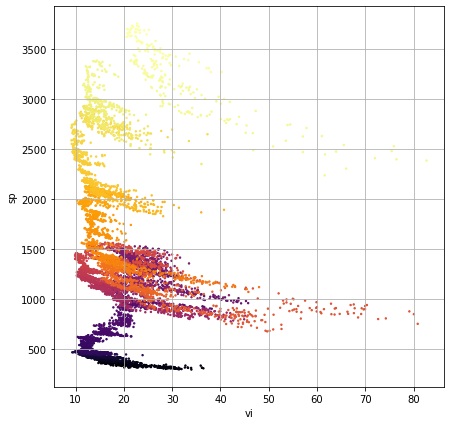

In [347]:
def scatter(col1, col2, lin):
    if lin == True:
        x = df[col1]/df[col1].max()
        y = df[col2]/df[col2].max()
    else:
        x = df[col1]
        y = df[col2]
        
    z = df.index.astype('int')/df.index.astype('int').max()
    color = [float(item) for item in z]
    plt.figure(figsize=(7,7))
#     plt.patch.set_facecolor('xkcd:grey')
    plt.scatter(x, y, s=2, c=color, cmap='inferno')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.grid(True)
    
    if lin == True:
        a = (np.sum(x)*np.sum(y) - len(x)*np.sum(x*y))/(np.sum(x)*np.sum(x) - len(x)*np.sum(x*x))
        b = (np.sum(y) - a*np.sum(x))/len(x)

        A = np.vstack([x, np.ones(len(x))]).T
        a1, b1 = np.linalg.lstsq(A, y)[0]
        print(a, b)
        print(a1, b1)
        plt.plot([0, 1], [b, a + b], c='r')
        plt.show()

    xm = np.mean(x)
    ym = np.mean(y)
    R = (np.sum((x - xm)*(y - ym)))/((np.sum((x - xm)**2)*np.sum((y - ym)**2))**(1/2))
    print('Коэффициент корреляции', R)
    plt.show()
    
scatter('vi', 'sp', False)

Коэффициент корреляции -0.03734501086418513


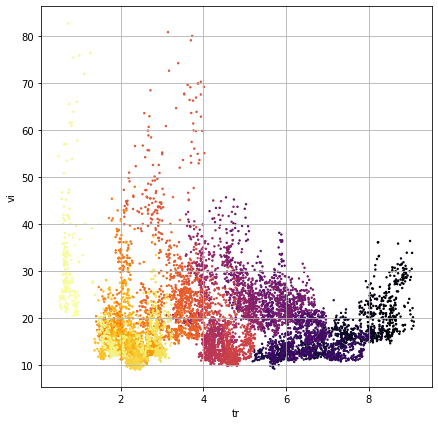

In [348]:
scatter('tr', 'vi', False)

Коэффициент корреляции -0.5949660710963853


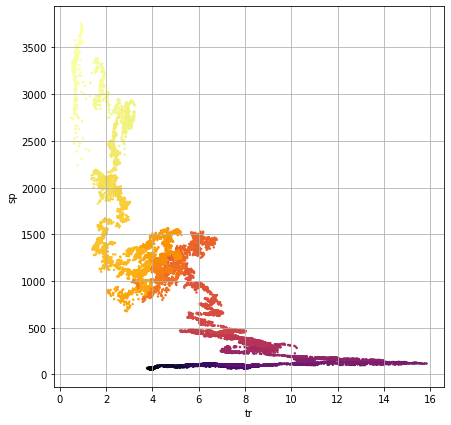

In [349]:
scatter('tr', 'sp', False)

In [350]:
df = df.drop('corr', axis=1)
df.date = pd.to_datetime(df.date)
df.index = df.date
df = df.drop('date', axis=1)

In [351]:
def fred(source, name):
    x = pd.read_csv('data/' + source).dropna()
    x = x.rename(columns={'DATE': 'date', x.columns[1]: name})
    x.date = pd.to_datetime(x.date)
    x.index = x.date
    x = x.drop('date', axis=1)
    x[name] = x[name].apply(pd.to_numeric, errors='coerce')
    return x

In [352]:
x = fred('DCOILBRENTEU.csv', 'br')
x.br = x.br.apply(pd.to_numeric, errors='coerce')
df = df.merge(x, on='date', how='left')
df.br = df.br.fillna(method='ffill')

In [353]:
x = fred('GOLD.csv', 'au')
x.au = x.au.apply(pd.to_numeric, errors='coerce')
df = df.merge(x, on='date', how='left')
df.au = df.au.fillna(method='ffill')

In [354]:
# x = fred('PCOPPUSDM.csv', 'cu')
# x.cu = x.cu.apply(pd.to_numeric, errors='coerce')
# df = df.merge(x, on='date', how='left')
# df.cu = df.cu.fillna(method='ffill')

In [355]:
x = fred('CBBTCUSD.csv', 'btc')
x.btc = x.btc.apply(pd.to_numeric, errors='coerce')
df = df.merge(x, on='date', how='left')
df.btc = df.btc.fillna(method='ffill')

In [356]:
x = fred('TREAST.csv', 'qe')
x.qe = x.qe.apply(pd.to_numeric, errors='coerce')
df = df.merge(x, on='date', how='left')
df.qe = df.qe.fillna(method='ffill')

In [357]:
df.head(2)

,sp,vi,tr,ns,ru,br,au,btc,qe
date,,,,,,,,,
1927-12-30,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,17.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Коэффициент корреляции -0.09734502620012898


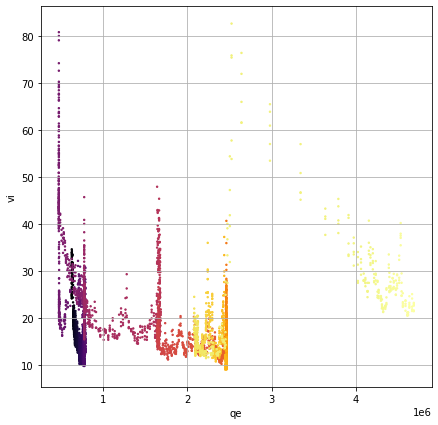

In [358]:
scatter('qe', 'vi', False)

In [359]:
# for i in df.columns:
#     for j in df.columns:
#         if i != j:
#             scatter(i, j, False)

Коэффициент корреляции 0.7989286189616237


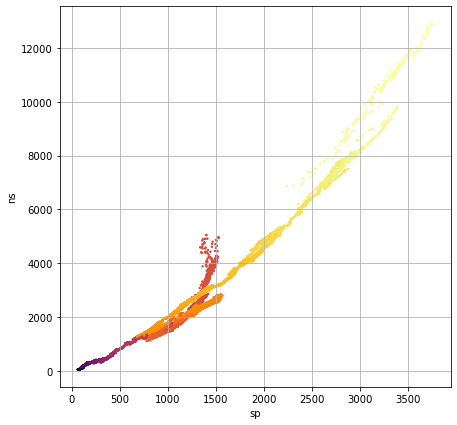

In [360]:
scatter('sp', 'ns', False)

Коэффициент корреляции 0.7944736168860392


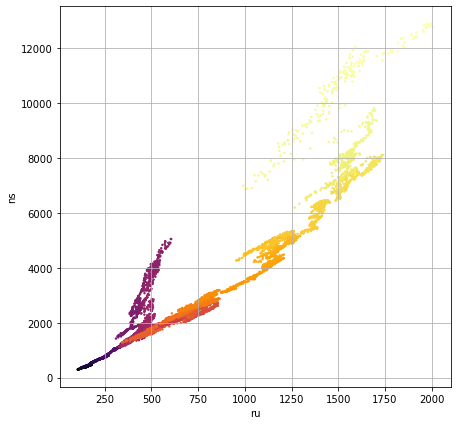

In [361]:
scatter('ru', 'ns', False)

In [362]:
df.sp[-5000:]

date
2001-02-16    1301.530029
2001-02-20    1278.939941
2001-02-21    1255.270020
2001-02-22    1252.819946
2001-02-23    1245.859985
                 ...     
2020-12-24    3703.060059
2020-12-28    3735.360107
2020-12-29    3727.040039
2020-12-30    3732.040039
2020-12-31    3756.070068
Name: sp, Length: 5000, dtype: float64

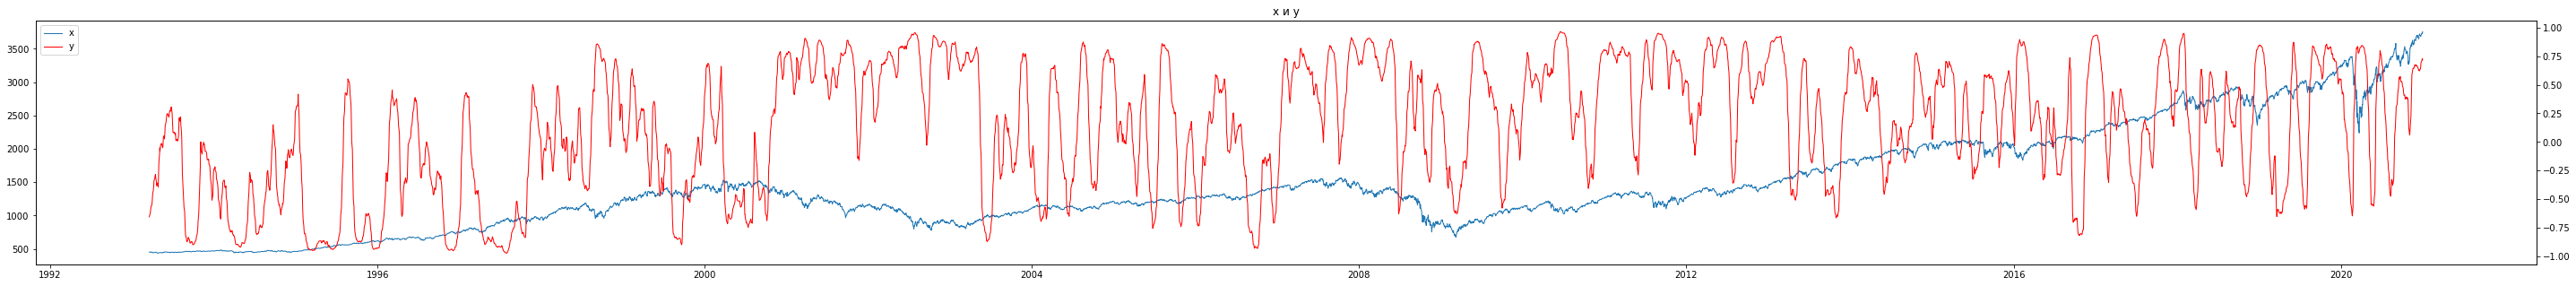

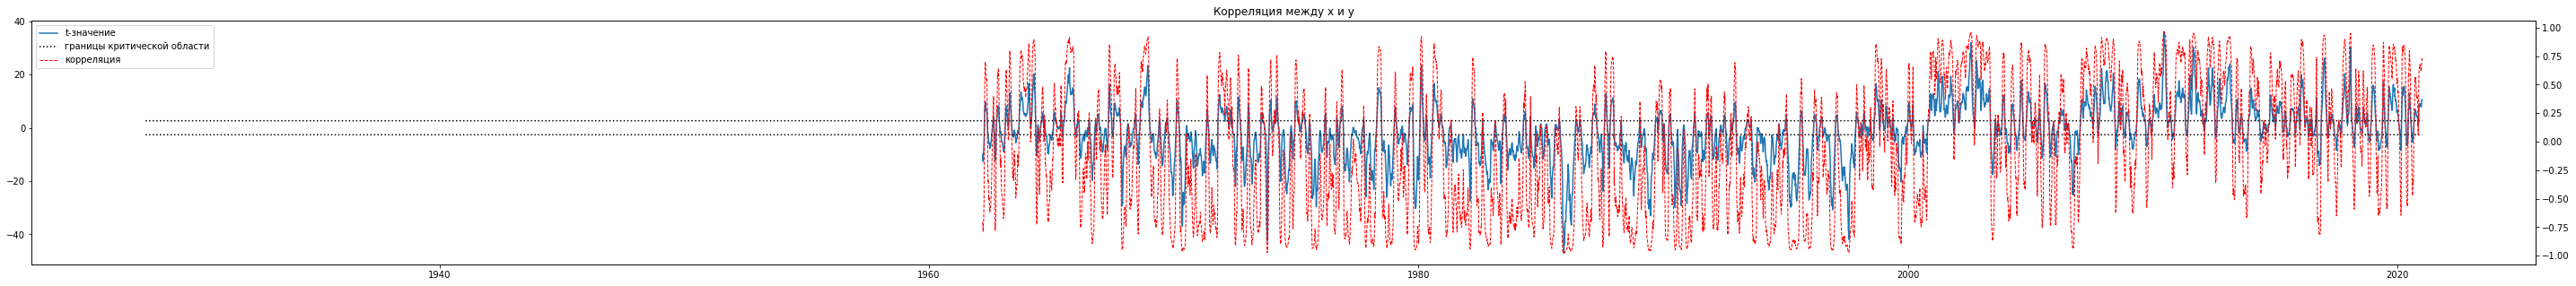

In [363]:
df['cor'] = df.sp.rolling(window=50).corr(df.tr)
corrt = t_st(df)
grapher(df[-7000:], 'sp', 'cor')

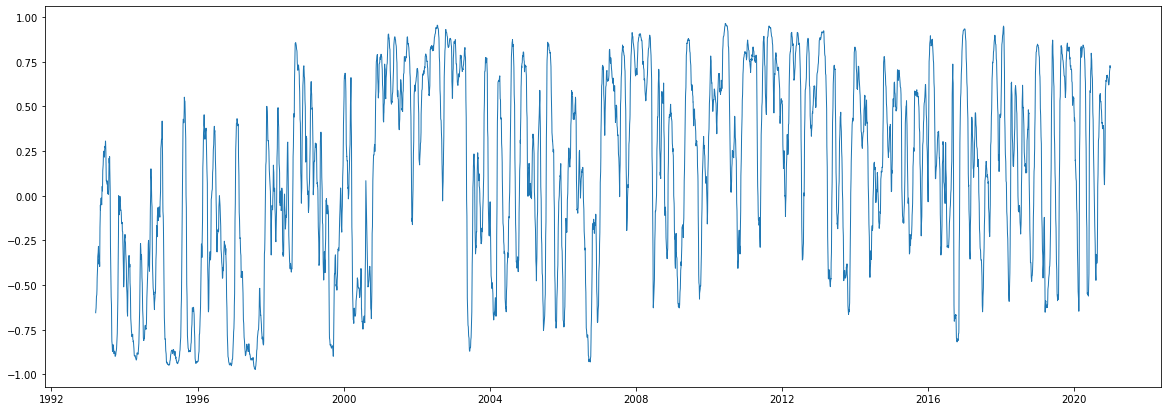

In [364]:

plt.figure(figsize=(20,7))
plt.plot(df.cor[-7000:], linewidth=1)

TypeError: float() argument must be a string or a number, not 'method'

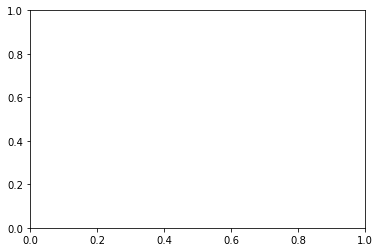

In [365]:
plt.plot(np.array(df.corr))

In [ ]:
# au = pd.read_csv('data/GOLD.csv').dropna()
# au = au.rename(columns={'DATE': 'date_added', 'GOLDAMGBD228NLBM': 'au'})
# au.date_added = pd.to_datetime(au.date_added)
# au.index = au.date_added
# au = au.drop('date_added', axis=1)
# au.au = au.au.apply(pd.to_numeric, errors='coerce')
# df = df.merge(au, on='date_added', how='left')
# df.au = df.au.fillna(method='ffill')